# Prerequisite

This notebook focuses constructing and evaluating the Match result predictive models.

**Prerequisite**: It requires to the prior execution of notebooks:
- `04_feature_engineering.ipynb`

# Data Pre-pocessing

## Loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

dim_team = pd.read_csv('../Data/dim_team.csv')


In [2]:
import pickle

with open('../Data/match_final_data.pkl', 'rb') as file:
    data = pickle.load(file)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   home_team            1531 non-null   object 
 1   away_team            1531 non-null   object 
 2   avg_home_shot        1531 non-null   float64
 3   avg_away_shot        1531 non-null   float64
 4   avg_home_sot         1531 non-null   float64
 5   avg_away_sot         1531 non-null   float64
 6   avg_home_pass        1531 non-null   float64
 7   avg_away_pass        1531 non-null   float64
 8   avg_home_corner      1531 non-null   float64
 9   avg_away_corner      1531 non-null   float64
 10  avg_home_clearance   1531 non-null   float64
 11  avg_away_clearance   1531 non-null   float64
 12  avg_home_save        1531 non-null   float64
 13  avg_away_save        1531 non-null   float64
 14  avg_home_goal        1531 non-null   float64
 15  avg_away_goal        1531 non-null   f

## Distribution of match result

result
Home    696
Away    449
Draw    386
Name: count, dtype: int64


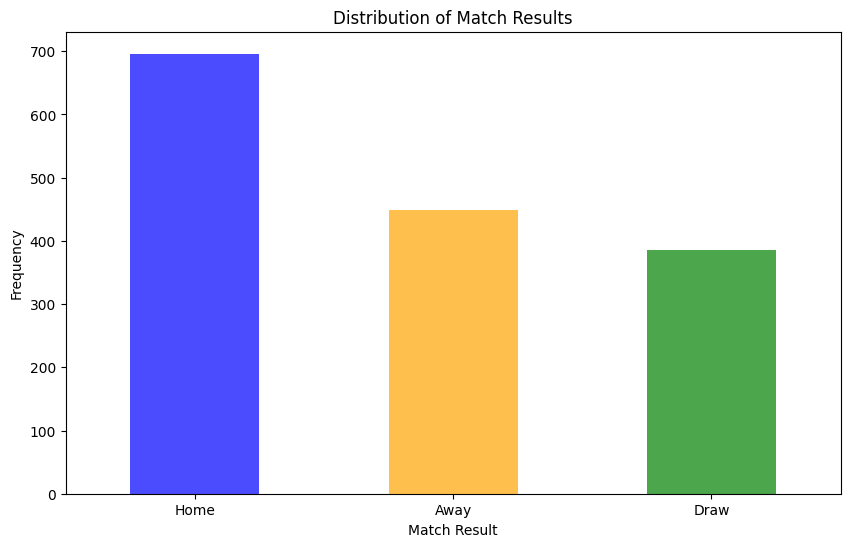

In [3]:
# Calculate the distribution of match results
result_distribution = data['result'].value_counts()
print(result_distribution)

# Plot the distribution of match results
plt.figure(figsize=(10, 6))
result_distribution.plot(kind='bar', color=['blue', 'orange', 'green'], alpha=0.7)
plt.title('Distribution of Match Results')
plt.xlabel('Match Result')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


## Encode match result

In [4]:
from sklearn.preprocessing import LabelEncoder

result_encoder = LabelEncoder()
data['result'] = result_encoder.fit_transform(data['result'])

## Bookmaker data

In [5]:
bookmaker_odds = pd.read_csv('../Data/bookmaker_odds.csv')

bookmaker_odds.head()

,home_team,away_team,home_goal,away_goal,result,B365A,B365D,B365H
0,Leganes,Alaves,1,0,Home,4.10,3.20,2.05
1,Valencia,Las Palmas,1,0,Home,4.50,3.80,1.75
2,Celta Vigo,Real Sociedad,2,3,Away,3.20,3.25,2.38
3,Girona,Atletico Madrid,2,2,Draw,1.45,4.33,8.00
4,Sevilla,Espanyol,1,1,Draw,5.50,4.00,1.62


In [6]:
def convert_odds_to_probs(odds):
    bookmaker_edge = 1/sum([1/o for o in odds])
    implied_probs = [(1/o)*bookmaker_edge for o in odds]
    total = sum(implied_probs)
    return [p/total for p in implied_probs]


In [7]:
import numpy as np


bookmaker_odds['bookmaker_pred_proba'] = bookmaker_odds[['B365A', 'B365D', 'B365H']].apply(lambda x: convert_odds_to_probs(x), axis=1)
bookmaker_odds['bookmaker_pred'] = bookmaker_odds['bookmaker_pred_proba'].apply(lambda x: np.argmax(x))

In [8]:
data = data.merge(bookmaker_odds[['home_team', 'away_team', 'bookmaker_pred_proba', 'bookmaker_pred']], on=['home_team', 'away_team'], how='left')

In [9]:
data.head()

,home_team,away_team,avg_home_shot,avg_away_shot,avg_home_sot,avg_away_sot,avg_home_pass,avg_away_pass,avg_home_corner,avg_away_corner,...,avg_away_xg,avg_home_ud_xg,avg_away_ud_xg,home_xg_vector,away_xg_vector,home_xg_time_vector,away_xg_time_vector,result,bookmaker_pred_proba,bookmaker_pred
0,Celta Vigo,Girona,12.333333,12.500000,3.500000,3.166667,492.333333,347.333333,5.333333,5.333333,...,1.046499,1.240646,1.435133,"[0.05315945417262, 0.08706667660013036, 0.0343...","[0.02038014185396191, 0.026675047007794783, 0....","[269.21093, 756.110394, 1084.59091, 1300.58282...","[104.97102799999999, 353.68608800000004, 517.3...",1,"[0.16555370444312875, 0.2644260557077751, 0.57...",2
1,Deportivo,Getafe,13.500000,12.333333,4.333333,3.833333,342.000000,275.166667,4.833333,4.833333,...,1.026756,1.187398,1.037020,"[0.09451974843490732, 0.11948241093346787, 0.5...","[0.11309811373122937, 0.03439931448848128, 0.0...","[313.10862599999996, 421.549125, 456.771684000...","[482.525167, 1481.710729, 1562.637261, 2909.90...",2,"[0.28111484863046615, 0.2940893801057184, 0.42...",2
2,Leganes,Atletico Madrid,10.833333,12.666667,5.000000,5.000000,325.666667,418.500000,2.666667,3.333333,...,0.989806,1.066449,1.230867,"[0.04605354293362127, 0.1331003080732824, 0.06...","[0.02321784876319893, 0.02272804784183438, 0.0...","[273.464051, 1202.144567, 1394.765361, 1398.67...","[71.481448, 818.3763960000001, 2073.321265, 30...",1,"[0.6172839506172839, 0.2551440329218107, 0.127...",0
3,Levante,Alaves,12.166667,9.000000,3.666667,2.666667,298.000000,293.000000,4.500000,2.666667,...,0.626754,1.257932,0.587910,"[0.11650468250248687, 0.05197437786303828, 0.0...","[0.08093467846588802, 0.7399004900871722, 0.04...","[57.771186, 60.727239, 948.872079, 1028.2768, ...","[734.630153, 966.8881369999999, 1833.506613, 2...",0,"[0.21076011846001974, 0.27097729516288255, 0.5...",2
4,Sevilla,Malaga,10.833333,11.000000,5.000000,4.166667,520.000000,399.500000,6.166667,4.500000,...,1.024673,1.615152,0.960092,"[0.15010169722802702, 0.6256478933958487, 0.07...","[0.15145944351477256, 0.02350404988765635, 0.2...","[1213.78689, 1542.617168, 1727.444833, 1862.26...","[572.214715, 1440.417623, 1789.883241, 3769.73...",2,"[0.12693025623621246, 0.17308671304938064, 0.6...",2


## Drop team names

In [10]:
data.drop(columns=['home_team', 'away_team'], inplace=True)

## Split data

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['result', 'bookmaker_pred_proba', 'bookmaker_pred']), 
    data[['result', 'bookmaker_pred_proba', 'bookmaker_pred']], 
    test_size=0.3, 
    stratify=data['result'],
    random_state=42
)

In [12]:
y_pred_bookmaker = y_test['bookmaker_pred']
y_pred_proba_bookmaker = np.stack(y_test['bookmaker_pred_proba'].values)

y_train = y_train['result']
y_test = y_test['result']

# Predictive Models

## Approach 1 - Aggregated Match xG

##### Base classifier

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import classification_report
import numpy as np

class match_predictor:
    def __init__(
        self, clf, 
        X_train=X_train, y_train=y_train, 
        X_test=X_test, y_test=y_test,
        goal_metric=['goal']
    ):
        self.clf = clf
        
        self.X_train = X_train.drop(columns=['home_xg_vector', 'away_xg_vector', 'home_xg_time_vector', 'away_xg_time_vector'])
        self.X_test = X_test.drop(columns=['home_xg_vector', 'away_xg_vector', 'home_xg_time_vector', 'away_xg_time_vector'])
        self.y_train = y_train
        self.y_test = y_test
        
        for metric in ['goal', 'xg', 'ud_xg']:
            if metric not in goal_metric:
                self.X_train = self.X_train.drop(columns=[f'avg_home_{metric}', f'avg_away_{metric}'])
                self.X_test = self.X_test.drop(columns=[f'avg_home_{metric}', f'avg_away_{metric}'])
                
        self.feat_names = self.X_train.columns
    
    def train(self):
        self.clf.fit(self.X_train, self.y_train)
    
    def predict(self, data=None):
        if data == None:
            data = self.X_test
        self.y_pred = self.clf.predict(data)
        self.y_pred_proba = self.clf.predict_proba(data)
        return self.y_pred, self.y_pred_proba
    
    def evaluate(self):
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.roc_auc = roc_auc_score(self.y_test, self.y_pred_proba, multi_class='ovr')
        self.f1 = f1_score(self.y_test, self.y_pred, average='weighted')
        self.precision = precision_score(self.y_test, self.y_pred, average='weighted')
        self.recall = recall_score(self.y_test, self.y_pred, average='weighted')
        self.log_loss_score = log_loss(self.y_test, self.y_pred_proba)
        
        y_test_onehot = np.zeros_like(self.y_pred_proba)
        y_test_onehot[np.arange(len(self.y_test)), self.y_test] = 1
        self.brier_score = np.mean(np.sum((self.y_pred_proba - y_test_onehot) ** 2, axis=1))
        
        print(classification_report(self.y_test, self.y_pred))
        print(f"Accuracy: {self.accuracy}")
        print(f"ROC AUC Score: {self.roc_auc}")
        print(f"F1 Score: {self.f1}")
        print(f"Precision: {self.precision}")
        print(f"Recall: {self.recall}")
        print(f"Log Loss: {self.log_loss_score}")
        print(f"Brier Score: {self.brier_score}")


### 1. Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np


def lr_model(scoring='accuracy', cv=5, smote=False):
    param_grid = {
        'clf__C': np.logspace(-5,5,100)
    }
    model = LogisticRegression(max_iter=100000)
    
    if smote:
        pipeline = ImbPipeline(
            [
                ('scaler', StandardScaler()),
                ('smote', SMOTE()),
                ('clf', model)
            ]
        )
    else:
        pipeline = Pipeline(
            [
                ('scaler', StandardScaler()),
                ('clf', model)
            ]
        )
    
    return GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring=scoring, cv=cv,)

#### a) LR without `xG`

In [15]:
lr_no_xg_model = lr_model()
lr_no_xg = match_predictor(lr_no_xg_model, goal_metric=['goal'])
lr_no_xg.train()
lr_no_xg.clf.best_params_

{'clf__C': 0.017073526474706904}

In [16]:
lr_no_xg.predict()
lr_no_xg.evaluate()

              precision    recall  f1-score   support

           0       0.52      0.55      0.54       135
           1       0.00      0.00      0.00       116
           2       0.55      0.83      0.67       209

    accuracy                           0.54       460
   macro avg       0.36      0.46      0.40       460
weighted avg       0.41      0.54      0.46       460

Accuracy: 0.5391304347826087
ROC AUC Score: 0.6829867361137264
F1 Score: 0.45969179555205353
Precision: 0.4057964140304154
Recall: 0.5391304347826087
Log Loss: 0.9574519075478629
Brier Score: 0.5675071531013534


#### b) LR with `xG`

In [17]:
lr_xg_model = lr_model()
lr_xg = match_predictor(lr_xg_model, goal_metric=['goal', 'xg'])
lr_xg.train()
lr_xg.clf.best_params_

{'clf__C': 0.013530477745798061}

In [18]:
lr_xg.predict()
lr_xg.evaluate()

              precision    recall  f1-score   support

           0       0.53      0.56      0.54       135
           1       0.00      0.00      0.00       116
           2       0.55      0.83      0.66       209

    accuracy                           0.54       460
   macro avg       0.36      0.46      0.40       460
weighted avg       0.41      0.54      0.46       460

Accuracy: 0.5413043478260869
ROC AUC Score: 0.6851682554259755
F1 Score: 0.46066675668377
Precision: 0.4062843241724142
Recall: 0.5413043478260869
Log Loss: 0.955923171150884
Brier Score: 0.566496675340625


#### c) LR with `Understat xG`

In [19]:
lr_ud_xg_model = lr_model()
lr_ud_xg = match_predictor(lr_ud_xg_model, goal_metric=['goal', 'ud_xg'])
lr_ud_xg.train()
lr_ud_xg.clf.best_params_

{'clf__C': 0.010722672220103232}

In [20]:
lr_ud_xg.predict()
lr_ud_xg.evaluate()

              precision    recall  f1-score   support

           0       0.54      0.53      0.53       135
           1       0.25      0.01      0.02       116
           2       0.55      0.85      0.67       209

    accuracy                           0.54       460
   macro avg       0.45      0.46      0.41       460
weighted avg       0.47      0.54      0.46       460

Accuracy: 0.5434782608695652
ROC AUC Score: 0.6857183431350821
F1 Score: 0.46375181056308695
Precision: 0.4705100522129507
Recall: 0.5434782608695652
Log Loss: 0.9559898048732518
Brier Score: 0.5665624866592118


### 2. Support Vector Machines

In [21]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np


def svc_model(scoring='accuracy', cv=5, smote=False):
    param_grid = {
        'clf__C': np.logspace(-5,5,100),
        'clf__gamma': ['scale', 'auto']
    }
    model = SVC(probability=True)
    
    if smote:
        pipeline = ImbPipeline(
            [
                ('scaler', StandardScaler()),
                ('smote', SMOTE()),
                ('clf', model)
            ]
        )
    else:
        pipeline = Pipeline(
            [
                ('scaler', StandardScaler()),
                ('clf', model)
            ]
        )
    
    return GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring=scoring, cv=cv)

#### a) SVC without `xG`

In [22]:
svc_no_xg_model = svc_model()
svc_no_xg = match_predictor(svc_no_xg_model, goal_metric=['goal'])
svc_no_xg.train()
svc_no_xg.clf.best_params_

{'clf__C': 0.22051307399030456, 'clf__gamma': 'scale'}

In [23]:
svc_no_xg.predict()
svc_no_xg.evaluate()

              precision    recall  f1-score   support

           0       0.63      0.32      0.42       135
           1       0.00      0.00      0.00       116
           2       0.52      0.97      0.68       209

    accuracy                           0.53       460
   macro avg       0.38      0.43      0.37       460
weighted avg       0.42      0.53      0.43       460

Accuracy: 0.5347826086956522
ROC AUC Score: 0.6432703829112713
F1 Score: 0.43126116998548497
Precision: 0.4208691085129704
Recall: 0.5347826086956522
Log Loss: 0.9904653687984244
Brier Score: 0.5907483068163363


#### b) SVC  with `xG`

In [24]:
svc_xg_model = svc_model()
svc_xg = match_predictor(svc_xg_model, goal_metric=['goal', 'xg'])
svc_xg.train()
svc_xg.clf.best_params_

{'clf__C': 0.7054802310718645, 'clf__gamma': 'scale'}

In [25]:
svc_xg.predict()
svc_xg.evaluate()

              precision    recall  f1-score   support

           0       0.58      0.39      0.46       135
           1       0.00      0.00      0.00       116
           2       0.53      0.94      0.68       209

    accuracy                           0.54       460
   macro avg       0.37      0.44      0.38       460
weighted avg       0.41      0.54      0.44       460

Accuracy: 0.5413043478260869
ROC AUC Score: 0.6453862786517478
F1 Score: 0.4449009423859499
Precision: 0.4127279155479651
Recall: 0.5413043478260869
Log Loss: 0.9986260570266858
Brier Score: 0.5959381859635128


#### c) SVC  with `Understat xG`

In [26]:
svc_ud_xg_model = svc_model()
svc_ud_xg = match_predictor(svc_ud_xg_model, goal_metric=['goal', 'ud_xg'])
svc_ud_xg.train()
svc_ud_xg.clf.best_params_

{'clf__C': 0.7054802310718645, 'clf__gamma': 'scale'}

In [27]:
svc_ud_xg.predict()
svc_ud_xg.evaluate()

              precision    recall  f1-score   support

           0       0.61      0.40      0.48       135
           1       0.00      0.00      0.00       116
           2       0.53      0.95      0.68       209

    accuracy                           0.55       460
   macro avg       0.38      0.45      0.39       460
weighted avg       0.42      0.55      0.45       460

Accuracy: 0.5478260869565217
ROC AUC Score: 0.6355653088324281
F1 Score: 0.4517083422574428
Precision: 0.42054758985933
Recall: 0.5478260869565217
Log Loss: 1.0002372126485983
Brier Score: 0.5968842205797161


### 3. Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np

def rf_model(scoring='accuracy', cv=5, smote=False):
    param_grid = {
        'clf__n_estimators': [100, 200, 300, 400, 500],
        'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'clf__criterion': ['gini', 'entropy', 'log_loss']
    }
    model = RandomForestClassifier(random_state=42)
    
    if smote:
        pipeline = ImbPipeline(
            [
                ('scaler', StandardScaler()),
                ('smote', SMOTE()),
                ('clf', model)
            ]
        )
    else:
        pipeline = Pipeline(
            [
                ('scaler', StandardScaler()),
                ('clf', model)
            ]
        )
    
    return GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring=scoring, cv=cv)

#### a) RF without `xG`

In [29]:
rf_no_xg_model = rf_model()
rf_no_xg = match_predictor(rf_no_xg_model, goal_metric=['goal'])
rf_no_xg.train()
rf_no_xg.clf.best_params_

{'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__n_estimators': 200}

In [30]:
rf_no_xg.predict()
rf_no_xg.evaluate()

              precision    recall  f1-score   support

           0       0.51      0.46      0.48       135
           1       0.04      0.01      0.01       116
           2       0.55      0.82      0.66       209

    accuracy                           0.51       460
   macro avg       0.37      0.43      0.39       460
weighted avg       0.41      0.51      0.44       460

Accuracy: 0.508695652173913
ROC AUC Score: 0.6613766862949981
F1 Score: 0.44449965485682674
Precision: 0.40877502455239106
Recall: 0.508695652173913
Log Loss: 0.9698798930516054
Brier Score: 0.575683711015897


#### b) RF with `xG`

In [31]:
rf_xg_model = rf_model()
rf_xg = match_predictor(rf_xg_model, goal_metric=['ud_xg'])
rf_xg.train()
rf_xg.clf.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 400}

In [32]:
rf_xg.predict()
rf_xg.evaluate()

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       135
           1       0.21      0.03      0.05       116
           2       0.55      0.88      0.67       209

    accuracy                           0.54       460
   macro avg       0.44      0.46      0.41       460
weighted avg       0.47      0.54      0.47       460

Accuracy: 0.5413043478260869
ROC AUC Score: 0.6680714780424807
F1 Score: 0.4675938501995117
Precision: 0.4680578671848849
Recall: 0.5413043478260869
Log Loss: 0.9616579108889126
Brier Score: 0.5694897093388576


#### c) RF with `Understat xG`

In [33]:
rf_ud_xg_model = rf_model()
rf_ud_xg = match_predictor(rf_ud_xg_model, goal_metric=['ud_xg'])
rf_ud_xg.train()
rf_ud_xg.clf.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 400}

In [34]:
rf_ud_xg.predict()
rf_ud_xg.evaluate()

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       135
           1       0.21      0.03      0.05       116
           2       0.55      0.88      0.67       209

    accuracy                           0.54       460
   macro avg       0.44      0.46      0.41       460
weighted avg       0.47      0.54      0.47       460

Accuracy: 0.5413043478260869
ROC AUC Score: 0.6680714780424807
F1 Score: 0.4675938501995117
Precision: 0.4680578671848849
Recall: 0.5413043478260869
Log Loss: 0.9616579108889126
Brier Score: 0.5694897093388576


## Approach 1 - Aggregated Match xG (SMOTE)

### 1. Best LR model - with `Understat xG`

In [35]:
lr_ud_xg_2_model = lr_model(smote=True)
lr_ud_xg_2 = match_predictor(lr_ud_xg_2_model, goal_metric=['goal', 'xg'])
lr_ud_xg_2.train()
lr_ud_xg_2.clf.best_params_

{'clf__C': 1.2618568830660211e-05}

In [36]:
lr_ud_xg_2.predict()
lr_ud_xg_2.evaluate()

              precision    recall  f1-score   support

           0       0.47      0.66      0.55       135
           1       0.28      0.06      0.10       116
           2       0.62      0.73      0.67       209

    accuracy                           0.54       460
   macro avg       0.46      0.48      0.44       460
weighted avg       0.49      0.54      0.49       460

Accuracy: 0.5413043478260869
ROC AUC Score: 0.6894642503075884
F1 Score: 0.49200876835784146
Precision: 0.4918156727221782
Recall: 0.5413043478260869
Log Loss: 1.092567638406999
Brier Score: 0.6626240576379735


### 2. Best SVC model - with `Understat xG`

In [37]:
svc_ud_xg_2_model = svc_model(smote=True)
svc_ud_xg_2 = match_predictor(svc_ud_xg_2_model, goal_metric=['goal', 'xg'])
svc_ud_xg_2.train()
svc_ud_xg_2.clf.best_params_

{'clf__C': 49770.23564332114, 'clf__gamma': 'scale'}

In [38]:
svc_ud_xg_2.predict()
svc_ud_xg_2.evaluate()

              precision    recall  f1-score   support

           0       0.38      0.41      0.40       135
           1       0.21      0.17      0.19       116
           2       0.51      0.53      0.52       209

    accuracy                           0.41       460
   macro avg       0.37      0.37      0.37       460
weighted avg       0.40      0.41      0.40       460

Accuracy: 0.40652173913043477
ROC AUC Score: 0.5557294020962164
F1 Score: 0.4005825307592987
Precision: 0.3962327288104585
Recall: 0.40652173913043477
Log Loss: 1.190984773989007
Brier Score: 0.7015034308198845


### 3. Best RF model - with `Understat xG`

In [39]:
rf_ud_xg_2_model = rf_model(smote=True)
rf_ud_xg_2 = match_predictor(rf_ud_xg_2_model, goal_metric=['goal'])
rf_ud_xg_2.train()
rf_ud_xg_2.clf.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 40, 'clf__n_estimators': 500}

In [40]:
rf_ud_xg_2.predict()
rf_ud_xg_2.evaluate()

              precision    recall  f1-score   support

           0       0.45      0.52      0.48       135
           1       0.23      0.16      0.18       116
           2       0.60      0.64      0.62       209

    accuracy                           0.48       460
   macro avg       0.42      0.44      0.43       460
weighted avg       0.46      0.48      0.47       460

Accuracy: 0.4826086956521739
ROC AUC Score: 0.6528424423045407
F1 Score: 0.468476912348003
Precision: 0.460104887529715
Recall: 0.4826086956521739
Log Loss: 0.9848052406914705
Brier Score: 0.5876742608695652


## Approach 2 - Individual xG values

##### Base classifier

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import classification_report
from keras import callbacks, layers, models
import tensorflow as tf
import numpy as np


tf.random.set_seed(42)

class ann_match_predictor:
    def __init__(
        self, 
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        xg_included=True,
        smote=False,
        n_last_shots=20
    ):
        self.smote = smote
        self.xg_included = xg_included
        
        self.X_train = X_train.drop(columns=['avg_home_xg', 'avg_away_xg', 'avg_home_ud_xg', 'avg_away_ud_xg'])
        self.X_test = X_test.drop(columns=['avg_home_xg', 'avg_away_xg', 'avg_home_ud_xg', 'avg_away_ud_xg'])
        self.y_train = y_train
        self.y_test = y_test
        
        # pre-process xg_vector, xg_time_vector
        self.X_train_home_xg_flattened = self.pre_process_vector(self.X_train, 'home_xg_vector', max_length=n_last_shots)
        self.X_train_home_xg_time_flattened = self.pre_process_vector(self.X_train, 'home_xg_time_vector', max_length=n_last_shots)
        self.X_train_away_xg_flattened = self.pre_process_vector(self.X_train, 'away_xg_vector', max_length=n_last_shots)
        self.X_train_away_xg_time_flattened = self.pre_process_vector(self.X_train, 'away_xg_time_vector', max_length=n_last_shots)
        
        self.X_test_home_xg_flattened = self.pre_process_vector(self.X_test, 'home_xg_vector', max_length=n_last_shots)
        self.X_test_home_xg_time_flattened = self.pre_process_vector(self.X_test, 'home_xg_time_vector', max_length=n_last_shots)
        self.X_test_away_xg_flattened = self.pre_process_vector(self.X_test, 'away_xg_vector', max_length=n_last_shots)
        self.X_test_away_xg_time_flattened = self.pre_process_vector(self.X_test, 'away_xg_time_vector', max_length=n_last_shots)
        
        # combine xg_vector, xg_time_vector
        self.X_train_home_xg = np.stack([self.X_train_home_xg_flattened, self.X_train_home_xg_time_flattened], axis=-1)
        self.X_train_away_xg = np.stack([self.X_train_away_xg_flattened, self.X_train_away_xg_time_flattened], axis=-1)
        self.X_test_home_xg = np.stack([self.X_test_home_xg_flattened, self.X_test_home_xg_time_flattened], axis=-1)
        self.X_test_away_xg = np.stack([self.X_test_away_xg_flattened, self.X_test_away_xg_time_flattened], axis=-1)
        
        # pre-process other features
        self.X_train_others = self.X_train.drop(columns=['home_xg_vector', 'away_xg_vector', 'home_xg_time_vector', 'away_xg_time_vector']).values
        self.X_test_others = self.X_test.drop(columns=['home_xg_vector', 'away_xg_vector', 'home_xg_time_vector', 'away_xg_time_vector']).values
        other_scaler = StandardScaler()
        other_scaler.fit(self.X_train_others)
        self.X_train_others = other_scaler.transform(self.X_train_others)
        self.X_test_others = other_scaler.transform(self.X_test_others)
    
    def pre_process_vector(self, df, column, max_length):
        padded_vectors = df[column].apply(lambda x: np.pad(x[::-1], (0, max_length - len(x))) if len(x) < max_length else x[::-1][:max_length])
        flattened_vectors = np.vstack(padded_vectors.values)
        return flattened_vectors
    
    def ann_model(self, num_classes=3, learning_rate=0.001):
        input_shape = self.X_train_home_xg.shape
        other_shape = self.X_train_others.shape 
        
        if self.xg_included:
            # input layers
            home_input = layers.Input(shape=(input_shape[1], input_shape[2]), name='home_input')
            away_input = layers.Input(shape=(input_shape[1], input_shape[2]), name='away_input')
            other_input = layers.Input(shape=(other_shape[1],), name='other_input')
        
            # LSTM layers
            home_lstm = layers.LSTM(32, return_sequences=False)(home_input)
            away_lstm = layers.LSTM(32, return_sequences=False)(away_input)
        
            # concatenate layers
            combined = layers.concatenate([home_lstm, away_lstm, other_input])
        
            # first dense layers
            dense = layers.Dense(64, activation='relu')(combined)
            
        else:
            # input layer
            other_input = layers.Input(shape=(other_shape[1],), name='other_input') 
            
            # first dense layer
            dense = layers.Dense(64, activation='relu')(other_input)
        
        dense = layers.Dropout(0.2)(dense)
        dense = layers.Dense(32, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        dense = layers.Dense(16, activation='relu')(dense)
        dense = layers.Dropout(0.2)(dense)
        output = layers.Dense(num_classes, activation='softmax')(dense)
        
        if self.xg_included:
            model = models.Model(inputs=[home_input, away_input, other_input], outputs=output)
        else:
            model = models.Model(inputs=other_input, outputs=output)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        return model
    
    def train(self, batch_size=1, epochs=1000, lr=0.0001):
        self.clf = self.ann_model(learning_rate=lr)
        early_stopping = callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')
        if self.xg_included:
            self.history = self.clf.fit(
                [self.X_train_home_xg, self.X_train_away_xg, self.X_train_others],
                self.y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                verbose=1,
                callbacks=[early_stopping]
            )
        else:
            self.history = self.clf.fit(
                self.X_train_others,
                self.y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                verbose=1,
                callbacks=[early_stopping]
            )
    
    def predict(self, data=None):
        if data == None:
            if self.xg_included:
                data = [self.X_test_home_xg, self.X_test_away_xg, self.X_test_others]
            else:
                data = self.X_test_others
        self.y_pred_proba = self.clf.predict(data)
        self.y_pred = np.argmax(self.y_pred_proba, axis=-1)
        return self.y_pred, self.y_pred_proba
    
    def evaluate(self):
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.roc_auc = roc_auc_score(self.y_test, self.y_pred_proba, multi_class='ovr')
        self.f1 = f1_score(self.y_test, self.y_pred, average='weighted')
        self.precision = precision_score(self.y_test, self.y_pred, average='weighted')
        self.recall = recall_score(self.y_test, self.y_pred, average='weighted')
        self.log_loss_score = log_loss(self.y_test, self.y_pred_proba)
        
        y_test_one_hot = np.zeros_like(self.y_pred_proba)
        y_test_one_hot[np.arange(len(self.y_test)), self.y_test] = 1
        self.brier_score = np.mean(np.sum((self.y_pred_proba - y_test_one_hot) ** 2, axis=1))
        
        print(classification_report(self.y_test, self.y_pred))
        print(f"Accuracy: {self.accuracy}")
        print(f"ROC AUC Score: {self.roc_auc}")
        print(f"F1 Score: {self.f1}")
        print(f"Precision: {self.precision}")
        print(f"Recall: {self.recall}")
        print(f"Log Loss: {self.log_loss_score}")
        print(f"Brier Score: {self.brier_score}")

### a) ANN without `xG`

In [42]:
nn_no_xg = ann_match_predictor(xg_included=False)

In [43]:
nn_no_xg.train(lr=1e-5)

Epoch 1/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.3159 - loss: 1.1929 - val_accuracy: 0.3674 - val_loss: 1.1143
Epoch 2/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3178 - loss: 1.1869 - val_accuracy: 0.3814 - val_loss: 1.1001
Epoch 3/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.3582 - loss: 1.1589 - val_accuracy: 0.4233 - val_loss: 1.0894
Epoch 4/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.3684 - loss: 1.1512 - val_accuracy: 0.4233 - val_loss: 1.0811
Epoch 5/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.3661 - loss: 1.1253 - val_accuracy: 0.4465 - val_loss: 1.0735
Epoch 6/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3728 - loss: 1.1135 - val_accuracy: 0.4512 - val_loss: 1.0671
Epoch 7/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.3439 - loss: 1.1315 - val_accuracy: 0.4419 - val_loss: 1.0612
Epoch 8/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.3668 -

In [44]:
nn_no_xg.predict()
nn_no_xg.evaluate()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       135
           1       0.00      0.00      0.00       116
           2       0.56      0.83      0.67       209

    accuracy                           0.54       460
   macro avg       0.35      0.46      0.40       460
weighted avg       0.40      0.54      0.46       460

Accuracy: 0.5391304347826087
ROC AUC Score: 0.6715509739194253
F1 Score: 0.4579455395244869
Precision: 0.4011150977909104
Recall: 0.5391304347826087
Log Loss: 0.9744749983042145
Brier Score: 0.5791340470314026


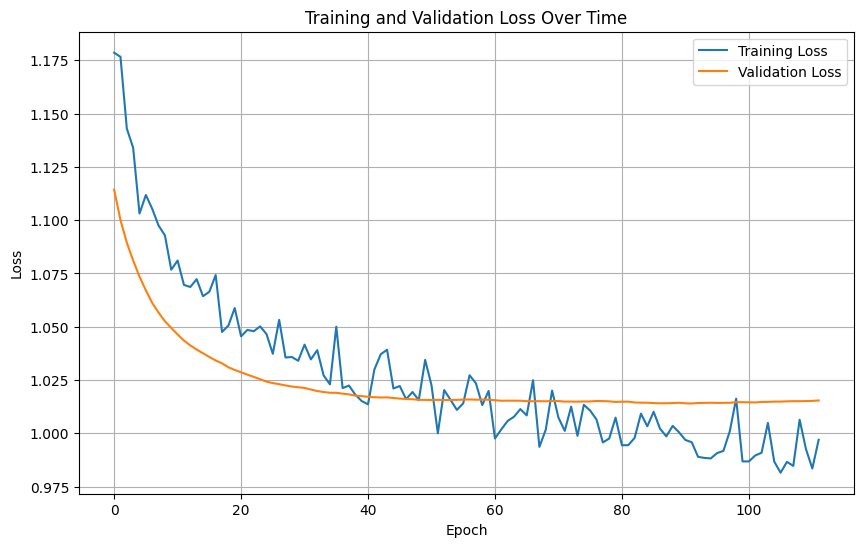

In [45]:
plt.figure(figsize=(10, 6))

# Plot training and validation loss values
plt.plot(nn_no_xg.history.history['loss'], label='Training Loss')

if 'val_loss' in nn_no_xg.history.history:
    plt.plot(nn_no_xg.history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

### b) ANN with `Goal` and `xG`

In [46]:
nn_xg = ann_match_predictor(xg_included=True)

In [47]:
nn_xg.train(lr=1e-5)

Epoch 1/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3659 - loss: 1.1503 - val_accuracy: 0.3395 - val_loss: 1.1196
Epoch 2/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3313 - loss: 1.1522 - val_accuracy: 0.3349 - val_loss: 1.0948
Epoch 3/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3470 - loss: 1.1553 - val_accuracy: 0.3953 - val_loss: 1.0782
Epoch 4/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3853 - loss: 1.1402 - val_accuracy: 0.4233 - val_loss: 1.0672
Epoch 5/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3792 - loss: 1.1224 - val_accuracy: 0.4558 - val_loss: 1.0587
Epoch 6/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3880 - loss: 1.1014 - val_accuracy: 0.4744 - val_loss: 1.0523
Epoch 7/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3865 - loss: 1.1003 - val_accuracy: 0.4837 - val_loss: 1.0475
Epoch 8/1000
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3654 - loss: 1.1336 - 

In [48]:
nn_xg.predict()
nn_xg.evaluate()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       135
           1       0.00      0.00      0.00       116
           2       0.54      0.84      0.66       209

    accuracy                           0.54       460
   macro avg       0.36      0.46      0.40       460
weighted avg       0.40      0.54      0.46       460

Accuracy: 0.5391304347826087
ROC AUC Score: 0.6703462501395615
F1 Score: 0.45659880055377683
Precision: 0.40373663455298753
Recall: 0.5391304347826087
Log Loss: 0.9696982757771917
Brier Score: 0.5773400068283081


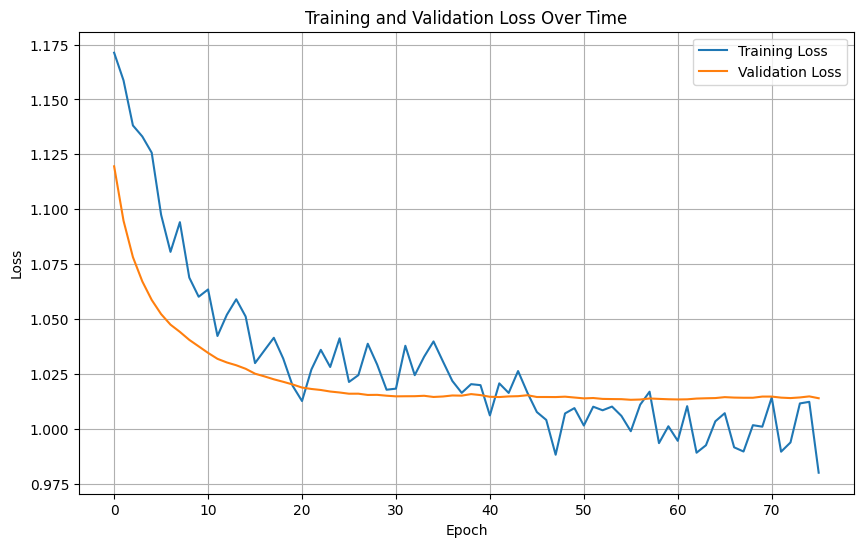

In [49]:
plt.figure(figsize=(10, 6))

# Plot training and validation loss values
plt.plot(nn_xg.history.history['loss'], label='Training Loss')

if 'val_loss' in nn_xg.history.history:
    plt.plot(nn_xg.history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Models Evaluation

##### Plotting data functions

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.calibration import calibration_curve, CalibrationDisplay


def plot_cm(y_test, y_pred, result_encoder=result_encoder):    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=result_encoder.classes_).plot()
    plt.show()

def plot_roc_auc(y_test, y_pred_proba, result_encoder=result_encoder, title=None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'{result_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')    
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')

def plot_calibration_curve(y_test, y_pred_proba, result='Home', result_encoder=result_encoder, label=None):
    for i, class_label in enumerate(result_encoder.classes_):
        if class_label == result:
            y_true = y_test == i
            prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_pred_proba[:, i], n_bins=10)
            plt.plot(prob_pred, prob_true, marker='o', label=label)

## Bookmaker Prediction

In [51]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import classification_report
import numpy as np

def evaluate(y_pred, y_pred_proba, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    log_loss_score = log_loss(y_test, y_pred_proba)
    
    y_test_one_hot = np.zeros_like(y_pred_proba)
    y_test_one_hot[np.arange(len(y_test)), y_test] = 1
    brier_score = np.mean(np.sum((y_test_one_hot - y_pred_proba)**2, axis=1))
    
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC Score: {roc_auc}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Log Loss: {log_loss_score}")
    print(f"Brier Score: {brier_score}")

In [52]:
evaluate(y_pred_bookmaker, y_pred_proba_bookmaker, y_test)

              precision    recall  f1-score   support

           0       0.56      0.63      0.59       135
           1       0.00      0.00      0.00       116
           2       0.59      0.87      0.70       209

    accuracy                           0.58       460
   macro avg       0.38      0.50      0.43       460
weighted avg       0.43      0.58      0.49       460

Accuracy: 0.5804347826086956
ROC AUC Score: 0.7089477151062789
F1 Score: 0.49372628905356053
Precision: 0.4325943935926773
Recall: 0.5804347826086956
Log Loss: 0.9237362790400544
Brier Score: 0.5458881152903503


## Accuracy Plot

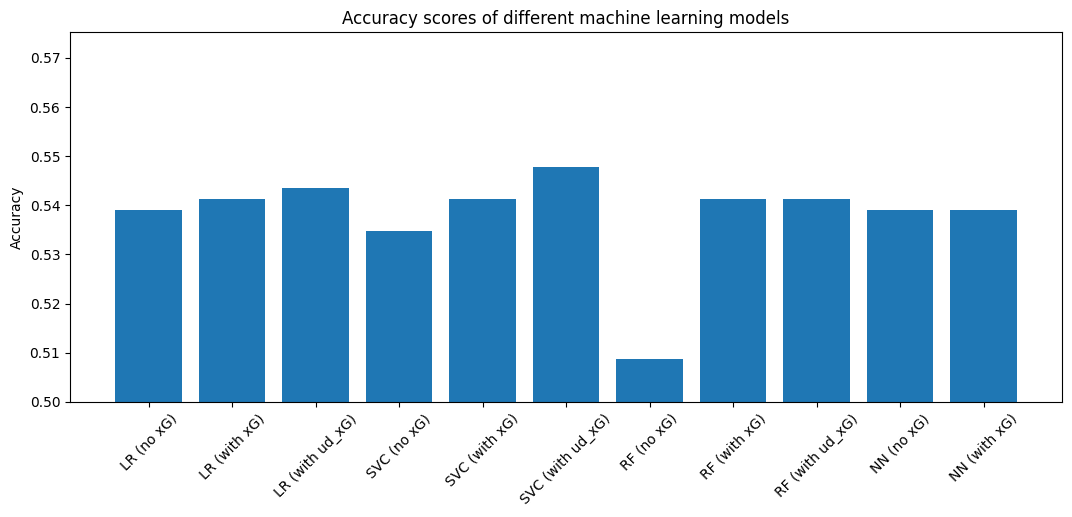

In [53]:
import matplotlib.pyplot as plt

model_names = ['LR (no xG)', 'LR (with xG)', 'LR (with ud_xG)', 'SVC (no xG)', 'SVC (with xG)', 'SVC (with ud_xG)', 'RF (no xG)', 'RF (with xG)', 'RF (with ud_xG)', 'NN (no xG)', 'NN (with xG)']
accuracy_scores = [lr_no_xg.accuracy, lr_xg.accuracy, lr_ud_xg.accuracy, svc_no_xg.accuracy, svc_xg.accuracy, svc_ud_xg.accuracy, rf_no_xg.accuracy, rf_xg.accuracy, rf_ud_xg.accuracy, nn_no_xg.accuracy, nn_xg.accuracy]


fig, ax = plt.subplots()

ax.bar(model_names, accuracy_scores)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy scores of different machine learning models')

ax.set_ylim(0.5)


plt.xticks(rotation=45)

fig.set_figwidth(fig.get_figwidth() * 2)
plt.show()


## Confusion matrix

### LR model

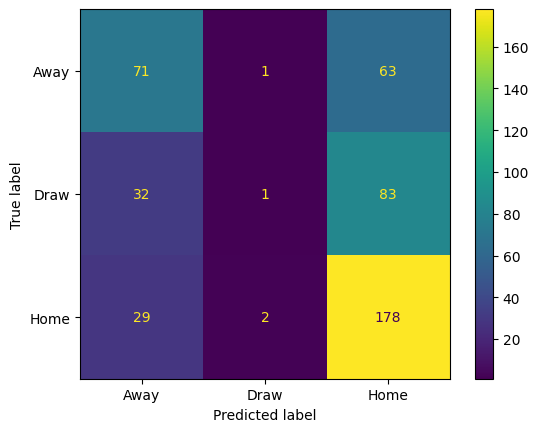

In [54]:
plot_cm(y_test, lr_ud_xg.y_pred)

### SVC model

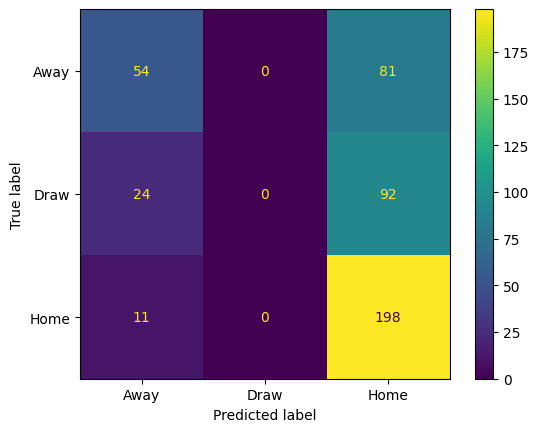

In [55]:
plot_cm(y_test, svc_ud_xg.y_pred)

### RF model

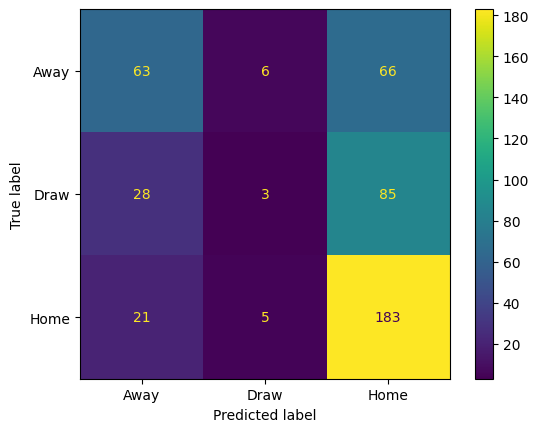

In [56]:
plot_cm(y_test, rf_ud_xg.y_pred)

### ANN model

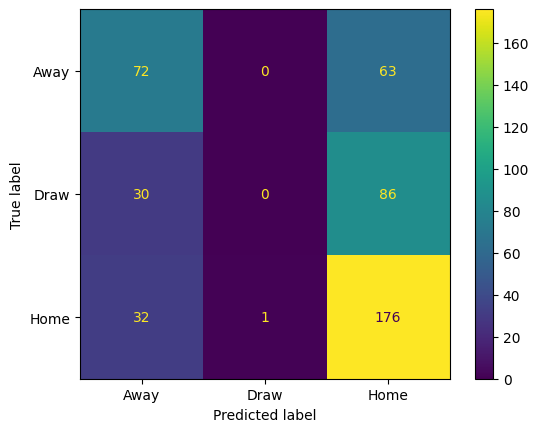

In [57]:
plot_cm(y_test, nn_xg.y_pred)

## ROC Curves

### Bookmaker

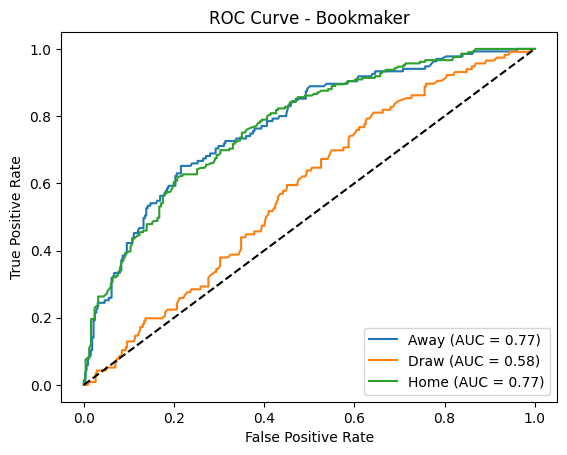

In [58]:
fig, ax = plt.subplots()

plot_roc_auc(y_test, y_pred_proba_bookmaker, title='Bookmaker')

### LR model

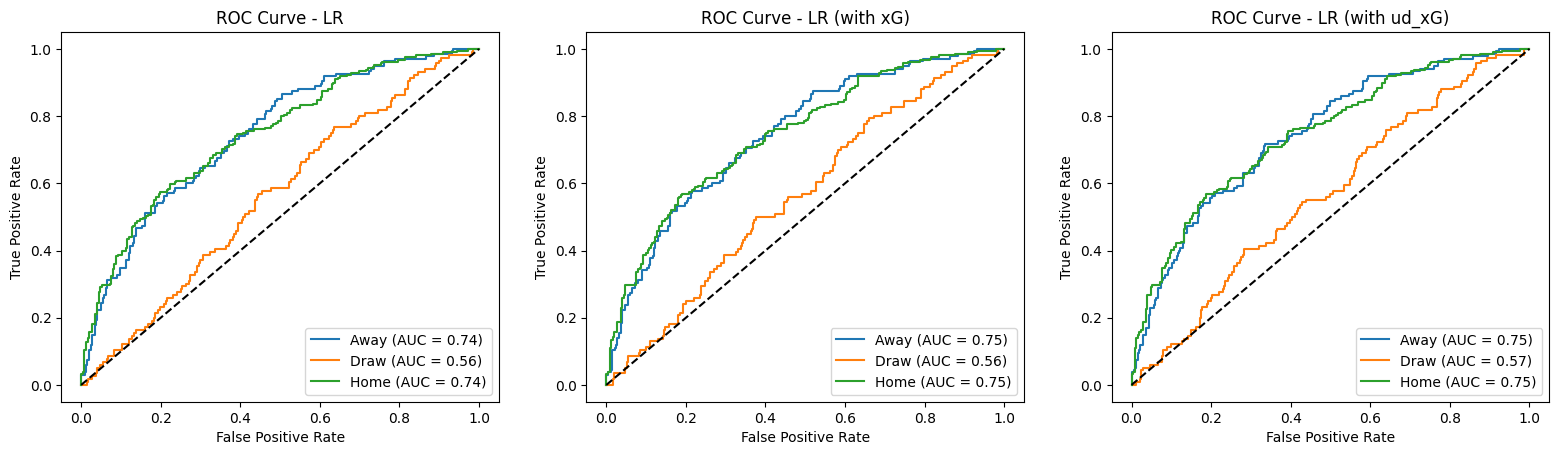

In [59]:
fig, ax = plt.subplots(1, 3)

plt.sca(ax[0])
plot_roc_auc(y_test, lr_no_xg.y_pred_proba, title='LR')

plt.sca(ax[1])
plot_roc_auc(y_test, lr_xg.y_pred_proba, title='LR (with xG)')

plt.sca(ax[2])
plot_roc_auc(y_test, lr_ud_xg.y_pred_proba, title='LR (with ud_xG)')

fig.set_figwidth(fig.get_figwidth() * 3)

### SVC model

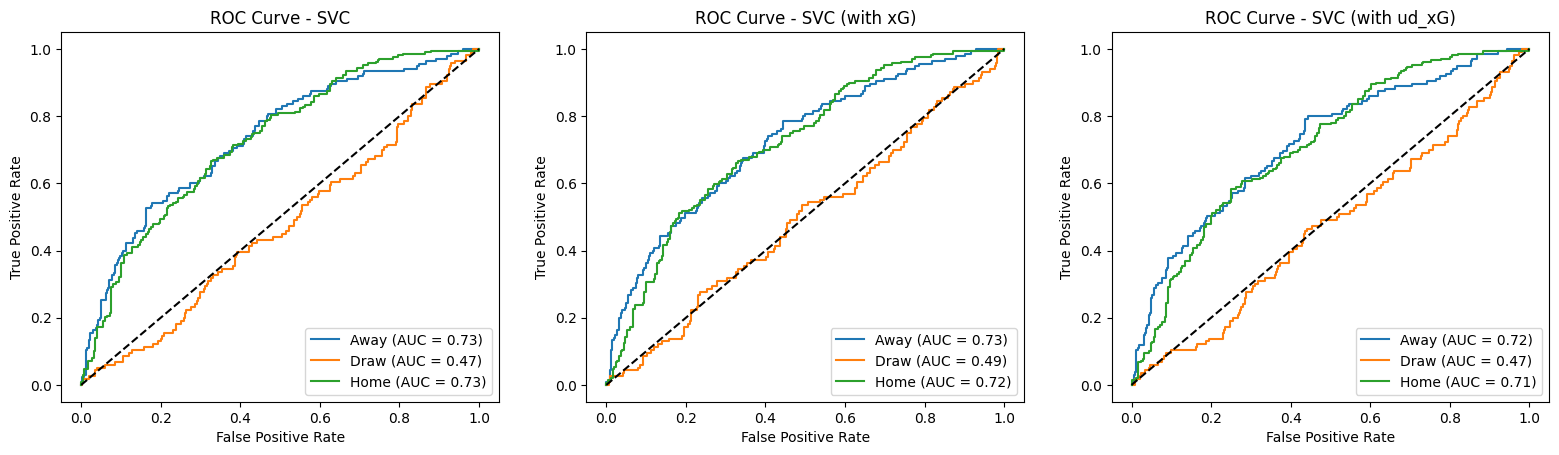

In [60]:
fig, ax = plt.subplots(1, 3)

plt.sca(ax[0])
plot_roc_auc(y_test, svc_no_xg.y_pred_proba, title='SVC')

plt.sca(ax[1])
plot_roc_auc(y_test, svc_xg.y_pred_proba, title='SVC (with xG)')

plt.sca(ax[2])
plot_roc_auc(y_test, svc_ud_xg.y_pred_proba, title='SVC (with ud_xG)')

fig.set_figwidth(fig.get_figwidth() * 3)

### RF model

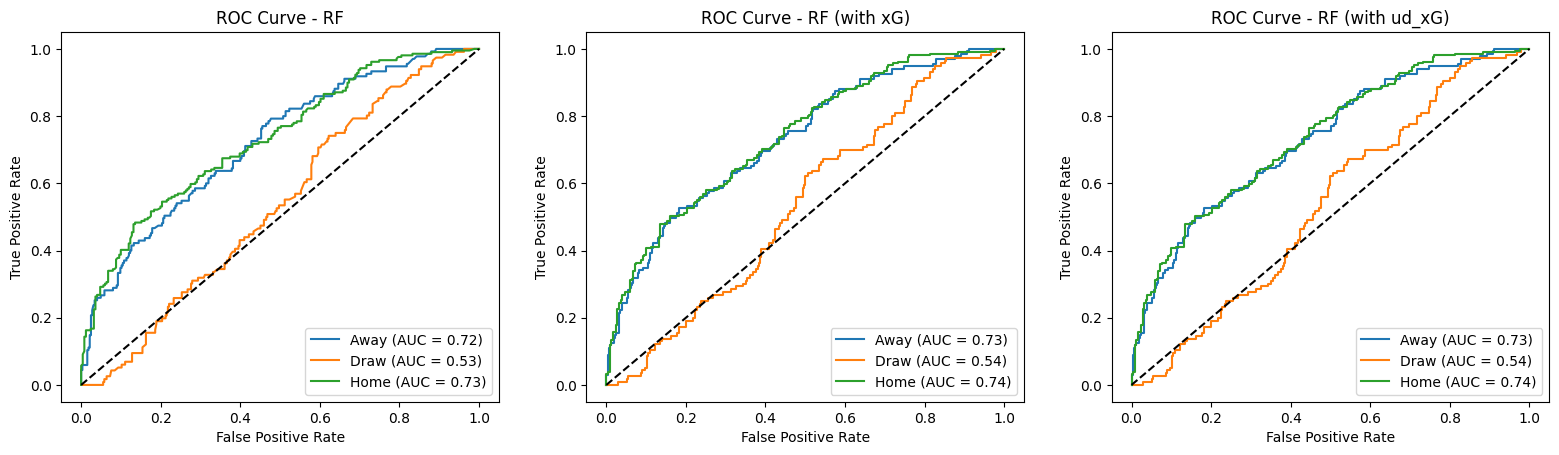

In [61]:
fig, ax = plt.subplots(1, 3)

plt.sca(ax[0])
plot_roc_auc(y_test, rf_no_xg.y_pred_proba, title='RF')

plt.sca(ax[1])
plot_roc_auc(y_test, rf_xg.y_pred_proba, title='RF (with xG)')

plt.sca(ax[2])
plot_roc_auc(y_test, rf_ud_xg.y_pred_proba, title='RF (with ud_xG)')

fig.set_figwidth(fig.get_figwidth() * 3)

### ANN model

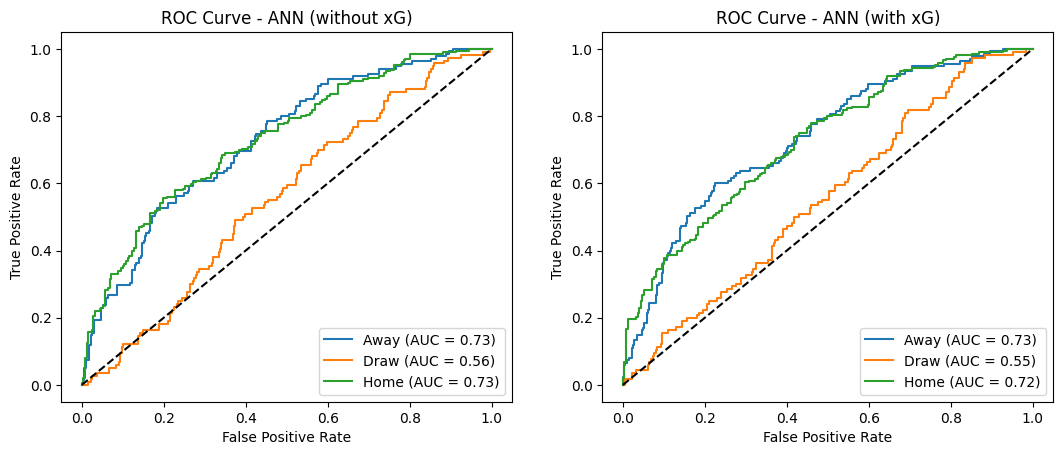

In [100]:
fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plot_roc_auc(y_test, nn_no_xg.y_pred_proba, title='ANN (without xG)')

plt.sca(ax[1])
plot_roc_auc(y_test, nn_xg.y_pred_proba, title='ANN (with xG)')

fig.set_figwidth(fig.get_figwidth() * 2)

## Calibration Curves

### Home wins

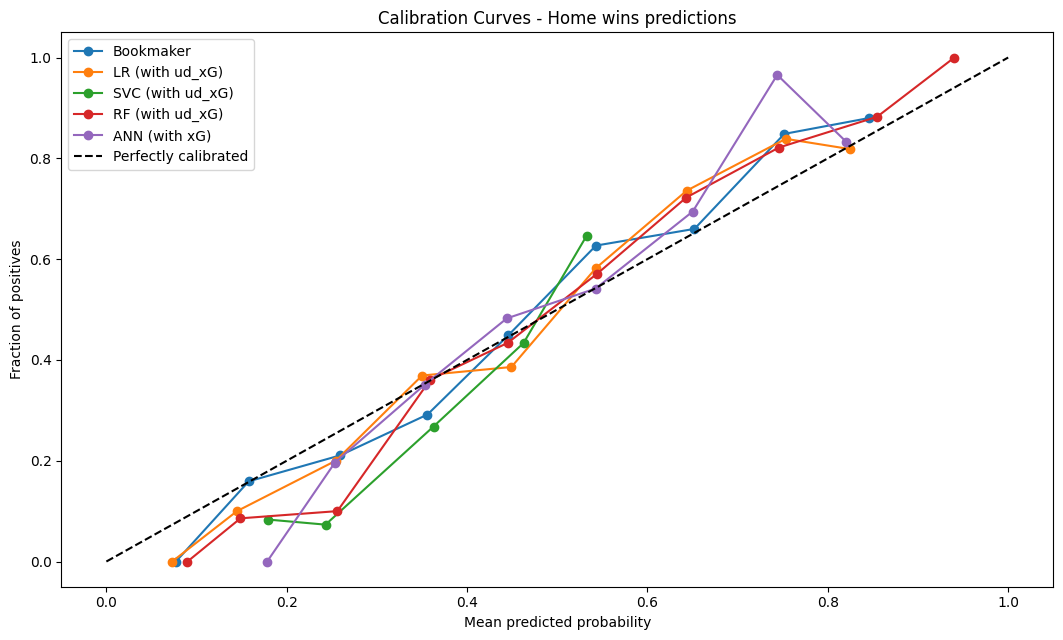

In [63]:
fig, ax = plt.subplots()

plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Home', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Home', label='LR (with ud_xG)')
plot_calibration_curve(y_test, svc_ud_xg.y_pred_proba, result='Home', label='SVC (with ud_xG)')
plot_calibration_curve(y_test, rf_ud_xg.y_pred_proba, result='Home', label='RF (with ud_xG)')
plot_calibration_curve(y_test, nn_xg.y_pred_proba, result='Home', label='ANN (with xG)')

ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves - Home wins predictions')
ax.legend(loc='best')

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1.5)

plt.show()

### Away wins

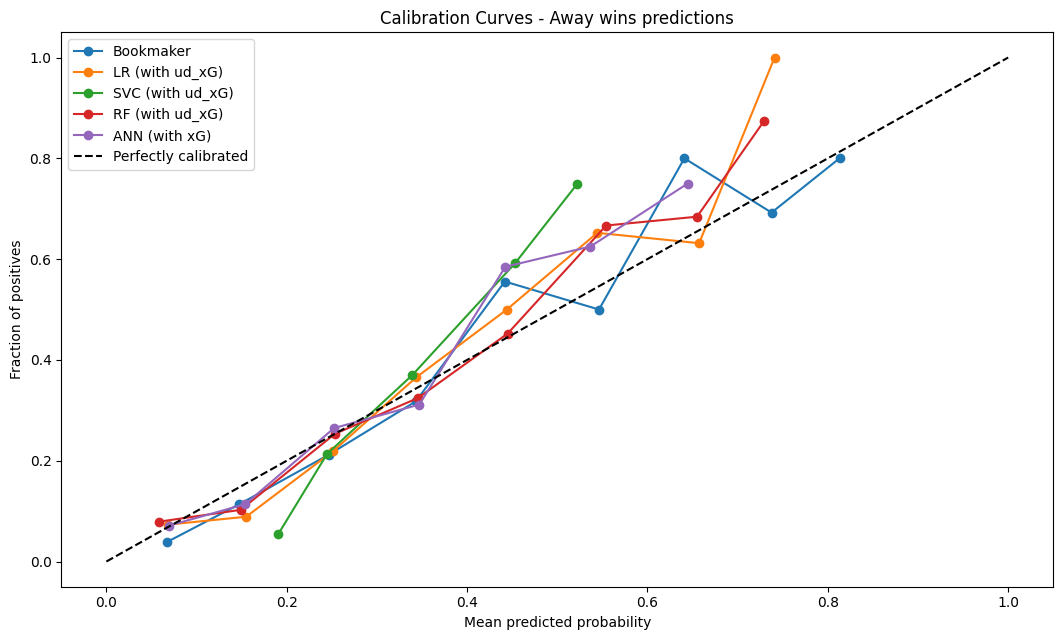

In [64]:
fig, ax = plt.subplots()

plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Away', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Away', label='LR (with ud_xG)')
plot_calibration_curve(y_test, svc_ud_xg.y_pred_proba, result='Away', label='SVC (with ud_xG)')
plot_calibration_curve(y_test, rf_ud_xg.y_pred_proba, result='Away', label='RF (with ud_xG)')
plot_calibration_curve(y_test, nn_xg.y_pred_proba, result='Away', label='ANN (with xG)')

ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves - Away wins predictions')
ax.legend(loc='best')

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1.5)

plt.show()

### Draw

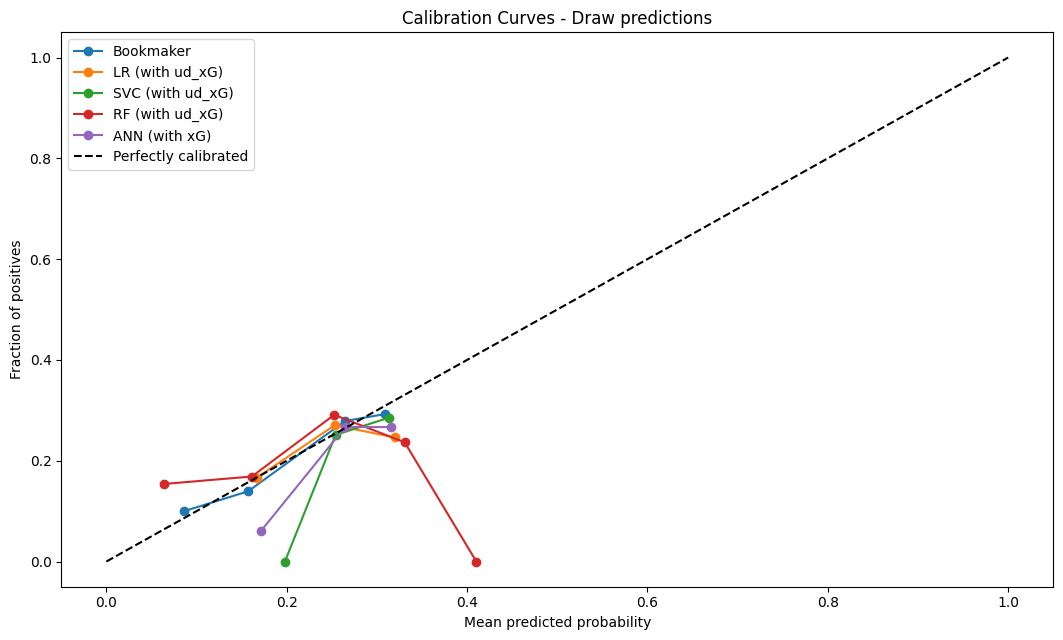

In [65]:
fig, ax = plt.subplots()

plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Draw', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Draw', label='LR (with ud_xG)')
plot_calibration_curve(y_test, svc_ud_xg.y_pred_proba, result='Draw', label='SVC (with ud_xG)')
plot_calibration_curve(y_test, rf_ud_xg.y_pred_proba, result='Draw', label='RF (with ud_xG)')
plot_calibration_curve(y_test, nn_xg.y_pred_proba, result='Draw', label='ANN (with xG)')

ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves - Draw predictions')
ax.legend(loc='best')

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1.5)

plt.show()

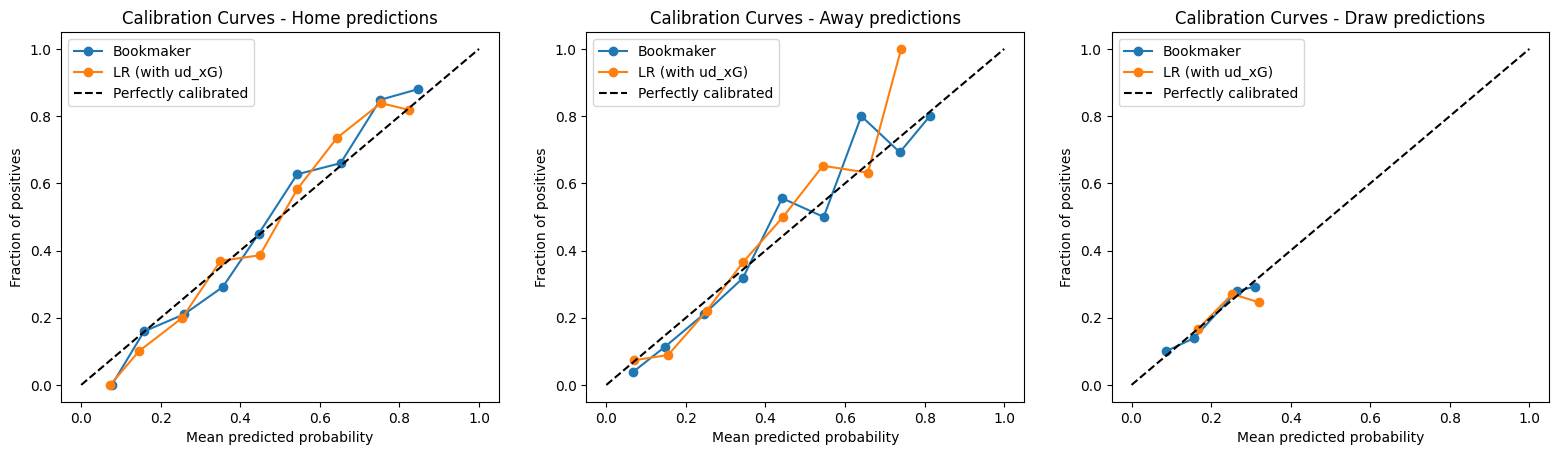

In [81]:
fig, ax = plt.subplots(1,3)

plt.sca(ax[0])
plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Home', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Home', label='LR (with ud_xG)')
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax[0].set_xlabel('Mean predicted probability')
ax[0].set_ylabel('Fraction of positives')
ax[0].set_title('Calibration Curves - Home predictions')
ax[0].legend(loc='best')

plt.sca(ax[1])
plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Away', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Away', label='LR (with ud_xG)')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax[1].set_xlabel('Mean predicted probability')
ax[1].set_ylabel('Fraction of positives')
ax[1].set_title('Calibration Curves - Away predictions')
ax[1].legend(loc='best')

plt.sca(ax[2])
plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Draw', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Draw', label='LR (with ud_xG)')
ax[2].plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax[2].set_xlabel('Mean predicted probability')
ax[2].set_ylabel('Fraction of positives')
ax[2].set_title('Calibration Curves - Draw predictions')
ax[2].legend(loc='best')

fig.set_figwidth(fig.get_figwidth() *3)
fig.set_figheight(fig.get_figheight() * 1)

plt.show()

## LR (with ud_xG) - SMOTE

In [66]:
lr_ud_xg_2.evaluate()

              precision    recall  f1-score   support

           0       0.47      0.66      0.55       135
           1       0.28      0.06      0.10       116
           2       0.62      0.73      0.67       209

    accuracy                           0.54       460
   macro avg       0.46      0.48      0.44       460
weighted avg       0.49      0.54      0.49       460

Accuracy: 0.5413043478260869
ROC AUC Score: 0.6894642503075884
F1 Score: 0.49200876835784146
Precision: 0.4918156727221782
Recall: 0.5413043478260869
Log Loss: 1.092567638406999
Brier Score: 0.6626240576379735


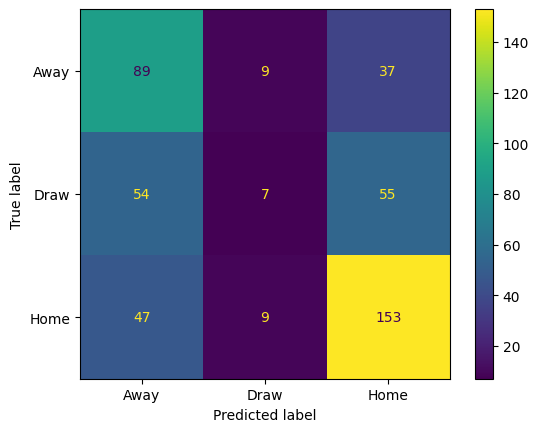

In [67]:
plot_cm(y_test, lr_ud_xg_2.y_pred)

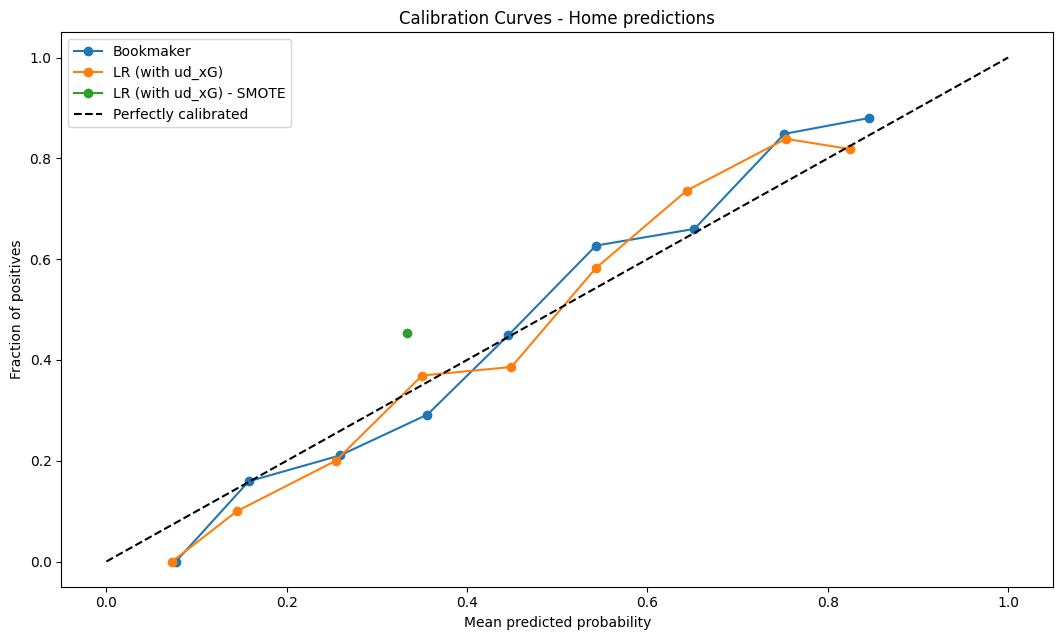

In [68]:
fig, ax = plt.subplots()

plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Home', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Home', label='LR (with ud_xG)')
plot_calibration_curve(y_test, lr_ud_xg_2.y_pred_proba, result='Home', label='LR (with ud_xG) - SMOTE')


ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves - Home predictions')
ax.legend(loc='best')

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1.5)

plt.show()

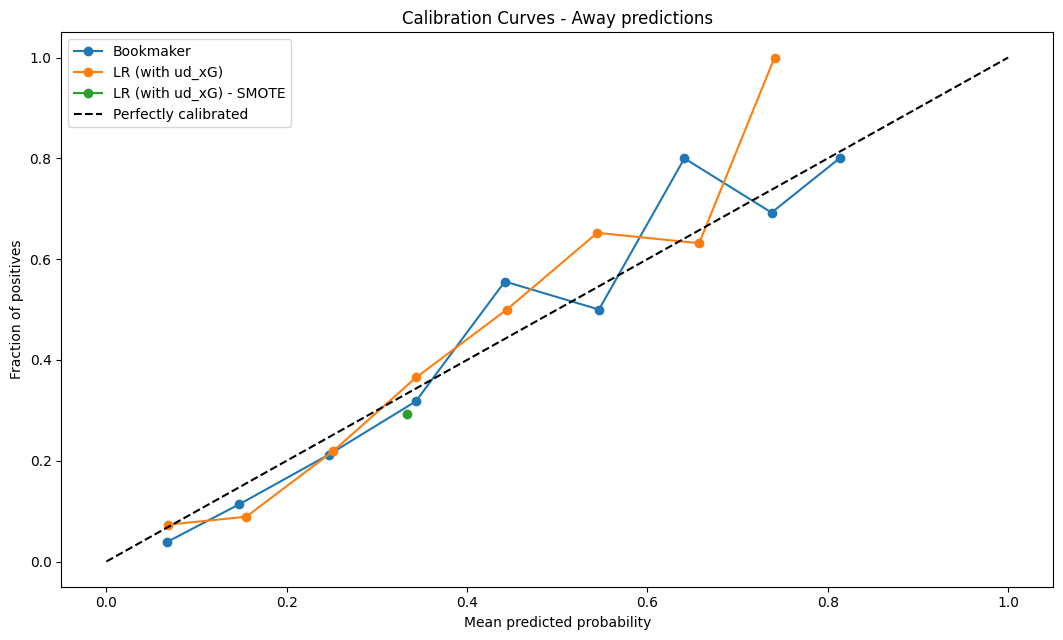

In [69]:
fig, ax = plt.subplots()

plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Away', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Away', label='LR (with ud_xG)')
plot_calibration_curve(y_test, lr_ud_xg_2.y_pred_proba, result='Away', label='LR (with ud_xG) - SMOTE')


ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves - Away predictions')
ax.legend(loc='best')

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1.5)

plt.show()

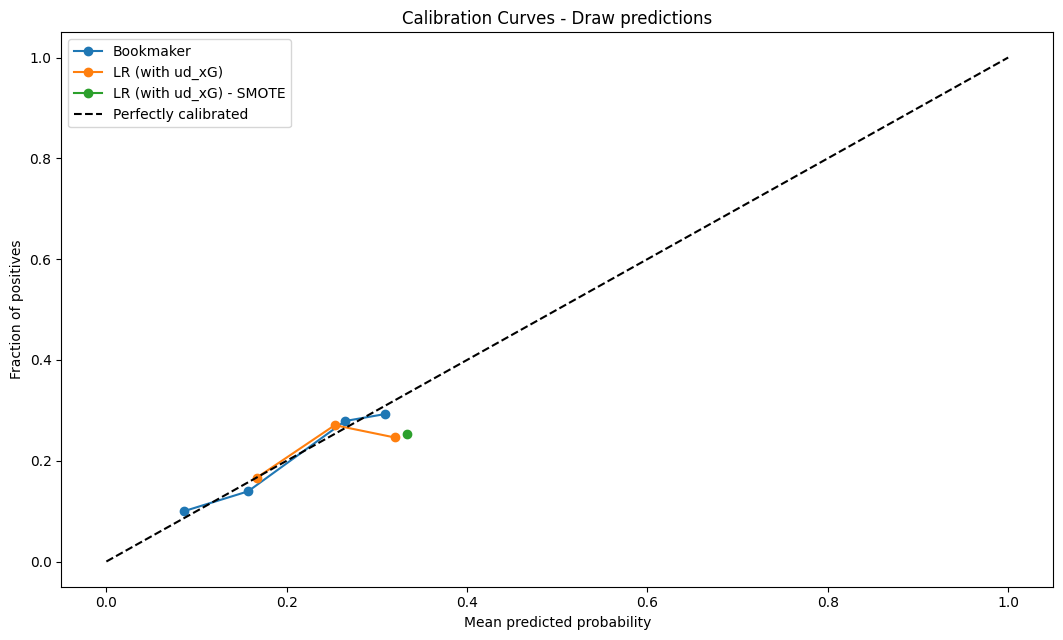

In [70]:
fig, ax = plt.subplots()

plot_calibration_curve(y_test, y_pred_proba_bookmaker, result='Draw', label='Bookmaker')
plot_calibration_curve(y_test, lr_ud_xg.y_pred_proba, result='Draw', label='LR (with ud_xG)')
plot_calibration_curve(y_test, lr_ud_xg_2.y_pred_proba, result='Draw', label='LR (with ud_xG) - SMOTE')


ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfectly calibrated')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves - Draw predictions')
ax.legend(loc='best')

fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 1.5)

plt.show()

# Feature Analysis

In [96]:
import shap

best_pipeline = lr_ud_xg.clf.best_estimator_
best_model = best_pipeline.named_steps['clf']


feat_names = lr_ud_xg.feat_names.tolist()

explainer = shap.Explainer(best_model, lr_ud_xg.X_train, feature_names=feat_names)
shap_values = explainer(lr_ud_xg.X_test)


Away wins

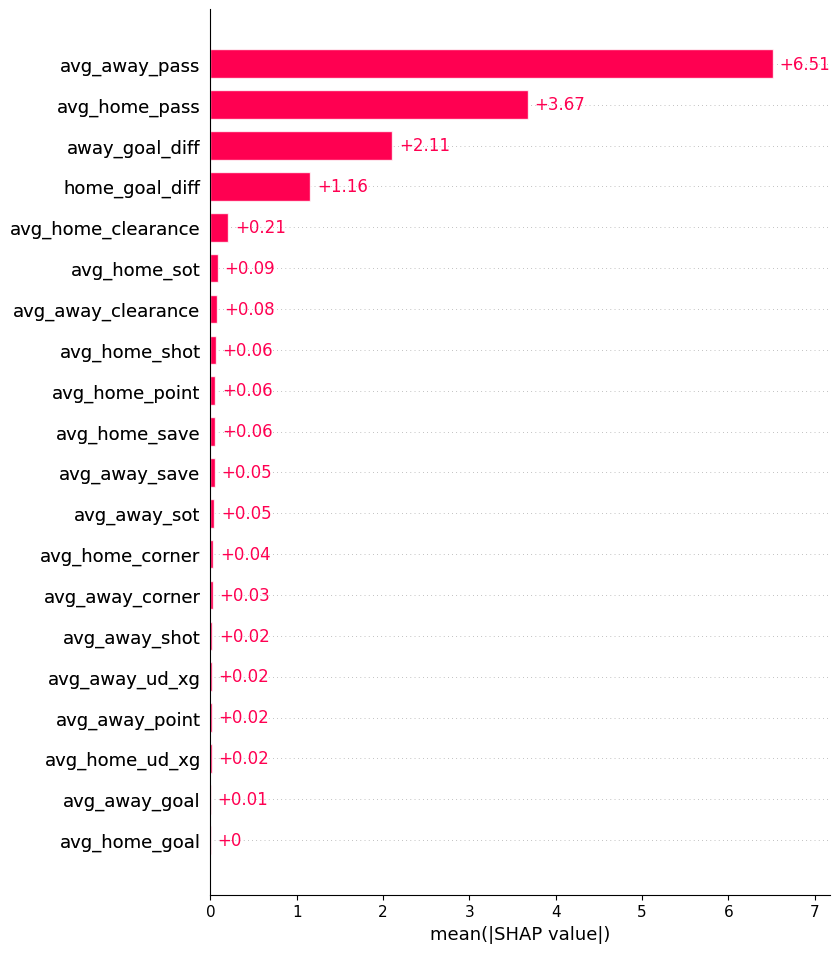

In [97]:
shap_values_away = shap_values[..., 0]
shap.plots.bar(shap_values_away, max_display=30)

Draw

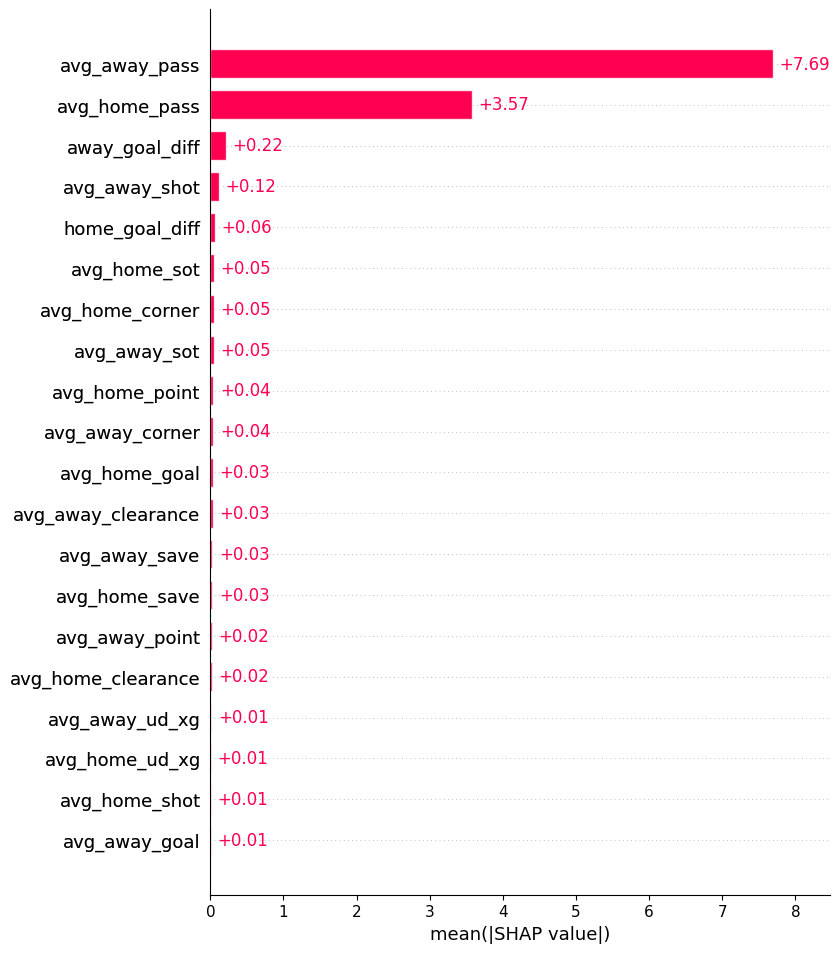

In [98]:
shap_values_draw = shap_values[..., 1]
shap.plots.bar(shap_values_draw, max_display=30)

Home wins

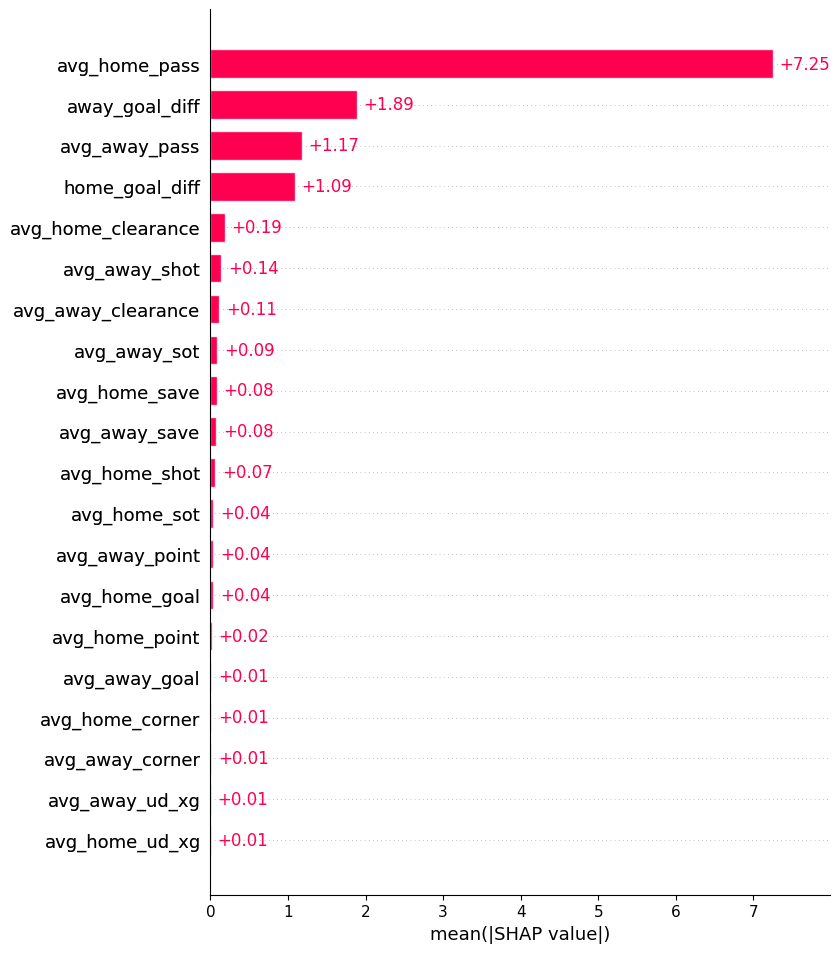

In [99]:
shap_values_home = shap_values[..., 2]
shap.plots.bar(shap_values_home, max_display=30)

In [94]:
import shap

best_pipeline = rf_ud_xg.clf.best_estimator_
best_model = best_pipeline.named_steps['clf']


feat_names = rf_ud_xg.feat_names.tolist()

explainer = shap.Explainer(best_model, rf_ud_xg.X_train, feature_names=feat_names)
shap_values = explainer(rf_ud_xg.X_test)


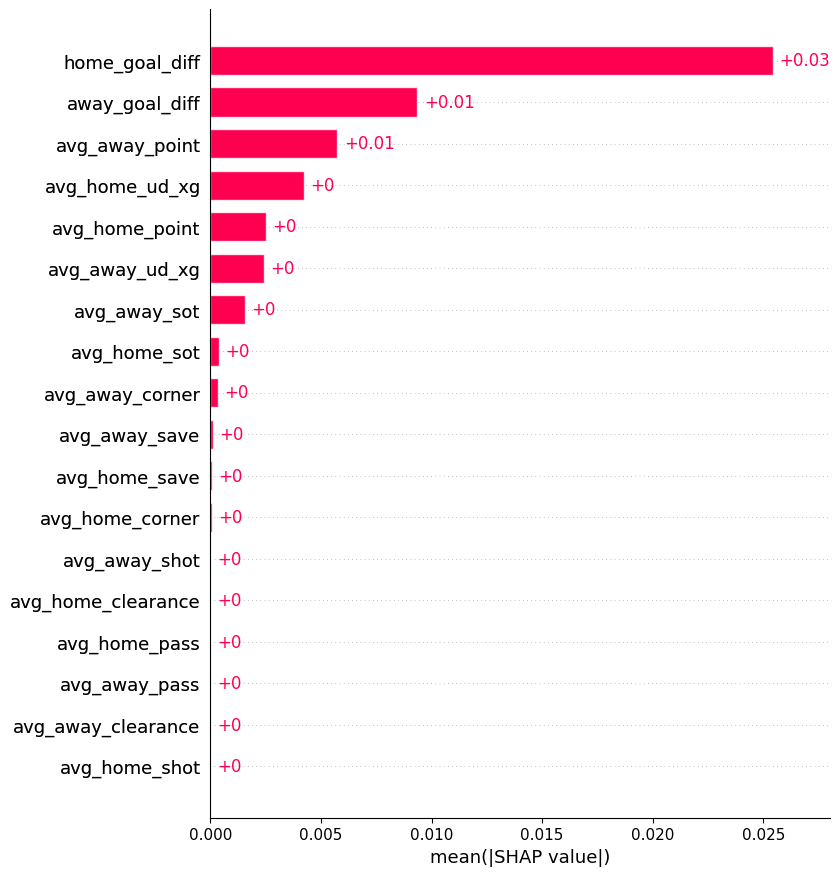

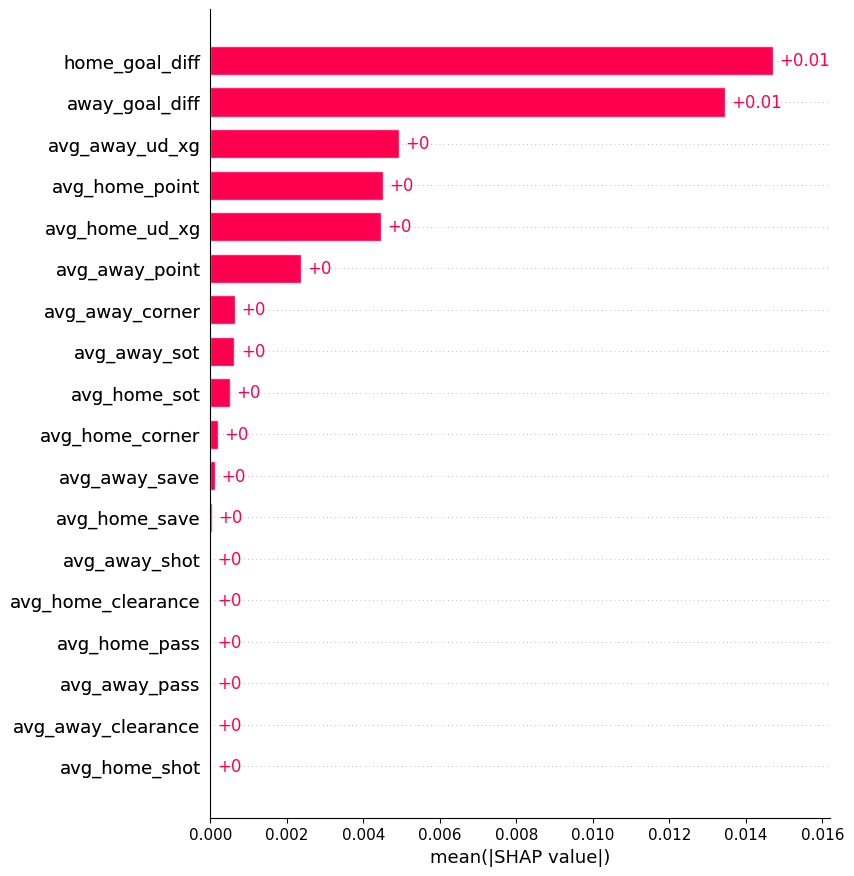

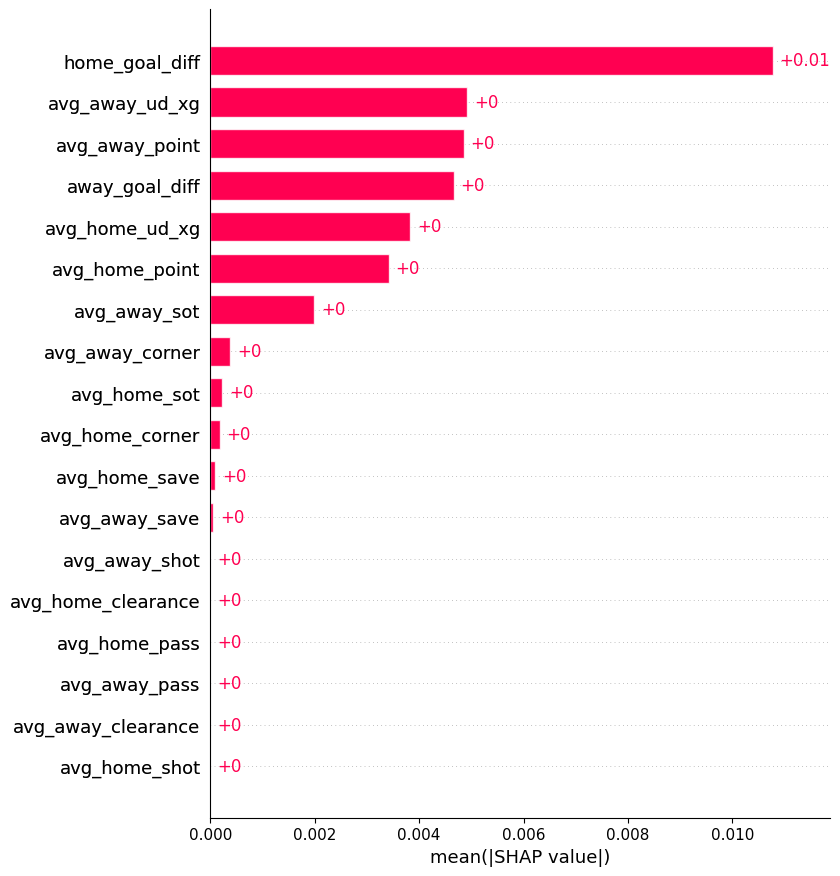

In [95]:
shap_values_draw = shap_values[..., 0]
shap.plots.bar(shap_values_draw, max_display=30)

shap_values_draw = shap_values[..., 1]
shap.plots.bar(shap_values_draw, max_display=30)

shap_values_home = shap_values[..., 2]
shap.plots.bar(shap_values_home, max_display=30)

# Saving model

In [102]:
import pickle

with open('../Models/Predictive Models/lr_no_xg.pkl', 'wb') as file:
    pickle.dump(lr_no_xg.clf, file)

with open('../Models/Predictive Models/lr_with_xg.pkl', 'wb') as file:
    pickle.dump(lr_xg.clf, file)
    
with open('../Models/Predictive Models/lr_with_ud_xg.pkl', 'wb') as file:
    pickle.dump(lr_ud_xg.clf, file)